In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import json
import seaborn as sns
from sklearn import linear_model
import sklearn as sk
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import statsmodels as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats as ss
from scipy import stats
import scipy.io as sio
from statsmodels import robust
from itertools import product
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', None)

In [3]:
fish = pd.read_csv('march_fish_100.csv', sep = ",")


In [4]:
len(fish)

320780

In [5]:
fish.head(2)

,index,trial_index,id,price_displayed,key pressed,environment,order,round_instance,task,function_id,quality_check,builtin_rt,end_time,start_time,Participant Public ID,key_pressed,latency
0,177473,1.0,668220.0,1.8,40.0,low,low-high,11.0,fishing,fishing_l,NaN,4.975,1.554475e+12,1.554475e+12,BLIND,40.0,109.0
1,177474,1.0,668220.0,1.8,40.0,low,low-high,11.0,fishing,fishing_l,NaN,29.965,1.554475e+12,1.554475e+12,BLIND,40.0,134.0


## Calculate fatigue

In [6]:
fish['tap_count']=[1]*len(fish)
# fatigue per environment


In [7]:
tap = fish.groupby(['id', 'environment'])['tap_count'].cumsum().reset_index(name = 'fatigue')


In [8]:
tap = tap.reset_index().set_index('index')

In [9]:
tap = tap.drop('level_0', axis =1)

In [10]:
fish = tap.merge(fish, left_index = True, right_index=True,how='inner')


## Exclusion list

In [37]:
fish = fish[~fish.id.isin([668262.0, 675528.0, 675577.0, 680119.0, 672593.0, 683242.0, 675654.0])]
# failed sound check questions                

In [38]:
fish.isnull().sum()
fish = fish[fish.latency.notnull()]

In [39]:
len(fish.id.unique())

93

In [40]:
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment'])
fish['environment_binary'] = np.where(fish['environment']=='low', 0, fish['environment_binary'])
fish['environment_binary'] = np.where(fish['environment']=='high', 1, fish['environment_binary'])
fish['log_latency'] = np.log(fish['latency'])


In [129]:
graph = fish.groupby(["price_displayed", "function_id"])['latency'].mean().reset_index()
graph.columns = ['price_displayed', 'function_id', 'average_latency']



In [140]:
sd = fish.groupby(["price_displayed", "function_id"])['latency'].sem().reset_index()


In [145]:

l_sd = sd.latency[(sd.function_id == 'fishing_l')]*3
h_sd = sd.latency[(sd.function_id == 'fishing_h')]*3


In [146]:
price = [0.1, 0.3, 0.7, 1.2, 1.8, 2.5]
latency_l = graph.average_latency[(graph.function_id == 'fishing_l')]
latency_h = graph.average_latency[(graph.function_id == 'fishing_h')]


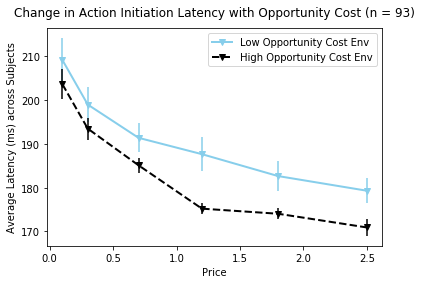

In [234]:
plt.plot( price, latency_l, marker='v', color='skyblue', linewidth=2, label = "Low Opportunity Cost Env")
plt.plot( price, latency_h, marker='v', color='black', linewidth=2, linestyle='dashed', label="High Opportunity Cost Env")
plt.errorbar(price, latency_l, l_sd, linestyle='None', marker='', color = 'skyblue', label = None)
plt.errorbar(price, latency_h, h_sd, linestyle='None', marker='', color = 'black', label = None)
plt.title("Change in Action Initiation Latency with Opportunity Cost (n = 93)", pad = 12)
plt.xlabel("Price")
plt.ylabel("Average Latency (ms) across Subjects")
plt.legend()
plt.savefig('price_latency.png', transparent=True, dpi=300)


In [203]:
rod = pd.read_csv('march_rod_100_no_first_spike.csv', sep = ",")


In [204]:
rod.head(1)

,index,trial_index,id,price_displayed,key pressed,environment,order,round_instance,task,function_id,quality_check,builtin_rt,end_time,start_time,Participant Public ID,key_pressed,latency,trial_label
0,187,3.0,668239.0,0.7,39.0,high,high-low,11.0,rod_fixing,rod_fixing,1.0,128.73,1.554475e+12,1.554475e+12,BLIND,39.0,130.0,3.0 11.0


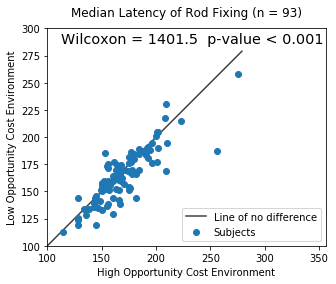

In [233]:
#For normalization, just do a scatterplot across your 100 subjects 
#of median latency 
#for the highest reward in low env vs the equivalent in high env. 
#If 2/3 are on one side of the line, it's an issue.

# Highest reward in low envrionemnt (0.5 pound worth 3000 yen) 2.5 
data_low= rod[(rod.environment == 'low')]
low_median = data_low.groupby('id')['latency'].median().reset_index(name = 'median_latency')
low_median['median_latency']
# the equivalent of 2.5 in low env is 0.3 in high environment
data_high = rod[(rod.environment == 'high')]
high_median = data_high.groupby('id')['latency'].median().reset_index(name = 'median_latency')
high_median['median_latency']

fig, ax = plt.subplots()
ax.scatter(low_median['median_latency'], high_median['median_latency'], label = 'Subjects')
ax.set_xlabel('High Opportunity Cost Environment')
ax.set_ylabel('Low Opportunity Cost Environment')
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
plt.xlim(100, 356)
plt.ylim(100, 300)
plt.annotate('Wilcoxon = 1401.5  p-value < 0.001', xy=(0.05, 0.93), xycoords='axes fraction', size = 'x-large')
x = np.arange(100, 280)
line = x
ax.plot(x, line, 'k-', alpha=0.75, zorder=0, label = 'Line of no difference')
plt.legend(loc = 4)
plt.title('Median Latency of Rod Fixing (n = 93)', pad = 12)
plt.savefig('rod.png', transparent=True, dpi=300)
ax.set_aspect('equal')
# people tap faster in the low environment --> maybe there is a price effect

In [231]:
ss.wilcoxon(low_median['median_latency'], high_median['median_latency'])

WilcoxonResult(statistic=1401.5, pvalue=0.0011070457988818542)

In [46]:
f_model = mixedlm(formula = 'log_latency ~ 1 + environment_binary + price_displayed + fatigue',
                  groups = fish['id'],
                  re_formula = "~environment_binary + price_displayed + fatigue",
                  data = fish)

r = f_model.fit(reml = True, method = 'bfgs')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [47]:
print(r.summary())

                          Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           log_latency
No. Observations:             295026            Method:                       REML       
No. Groups:                   93                Scale:                        0.0559     
Min. group size:              1355              Likelihood:                   5795.3136  
Max. group size:              4507              Converged:                    Yes        
Mean group size:              3172.3                                                     
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      5.252    0.023 230.326 0.000  5.207  5.297
environment_binary[T.1]             

In [48]:
sm.tools.eval_measures.aic(5795.3136, 298234, 4)

-11582.6272

In [33]:
print (r.tvalues)

Intercept                                        231.606915
environment_binary[T.1]                           -3.626177
price_displayed                                   -8.576034
fatigue                                            6.347674
Group Var                                          6.782330
Group x environment_binary[T.1] Cov               -5.096473
environment_binary[T.1] Var                        6.704656
Group x price_displayed Cov                       -5.513694
environment_binary[T.1] x price_displayed Cov      3.252476
price_displayed Var                                6.762714
Group x fatigue Cov                                3.607191
environment_binary[T.1] x fatigue Cov             -3.524278
price_displayed x fatigue Cov                     -2.180015
fatigue Var                                        6.526324
dtype: float64


In [49]:
#dir(r)

In [18]:
r_params = pd.DataFrame(r.params,columns=['LMM'])
random_effects = pd.DataFrame(r.random_effects)
random_effects = random_effects.transpose()
random_effects = random_effects.rename(index=str, columns={'groups': 'LMM'})

In [92]:
random_effects.head(2)

,Group,environment_binary[T.1],price_displayed,fatigue
668220.0,-0.081051,0.046051,0.003641,-0.000051
668225.0,0.119937,-0.107922,-0.087239,-0.000038


In [148]:
len(random_effects)

94

In [110]:
betas = pd.read_csv('akshay_betas.csv', sep = ",")

In [111]:
betas = betas.reset_index().set_index('id')

In [112]:
betas.head(2)

,index,environment,price
id,,,
668220.0,0,0.047904,0.003702
668225.0,1,-0.106306,-0.087299


In [114]:
betas.columns = ['id', 'env_mat', 'price_mat']



In [120]:
betas.index = betas.index.astype(str)

In [121]:
check = betas.merge(correlation_table, right_index = True, 
                    left_index = True, how = 'inner')




In [128]:
ss.spearmanr(check['env_mat'], check['depression'], nan_policy = 'omit')



SpearmanrResult(correlation=-0.24426871251889057, pvalue=0.01894688319280171)

In [170]:
ss.spearmanr(check['env_mat'], check['bAMI'], nan_policy = 'omit')

SpearmanrResult(correlation=-0.041381970157340006, pvalue=0.695307393271364)

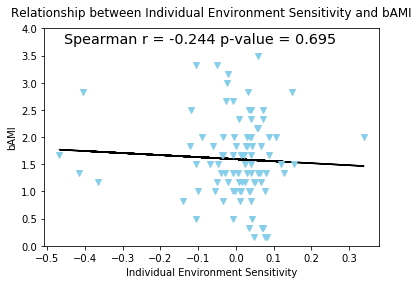

In [201]:
x = check['env_mat']
y = check['bAMI']

mask = ~np.isnan(x) & ~np.isnan(y)

slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
line = slope*x+intercept

plt.xlabel("Individual Environment Sensitivity")
plt.ylabel("bAMI")
plt.ylim([0, 4])
plt.plot(x, line, color = 'black')
plt.plot(x,y,'v', color = 'skyblue')
plt.title('Relationship between Individual Environment Sensitivity and bAMI', pad=12)
plt.annotate('Spearman r = -0.244 p-value = 0.695', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('bAMI.png', transparent=True, dpi=300)
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

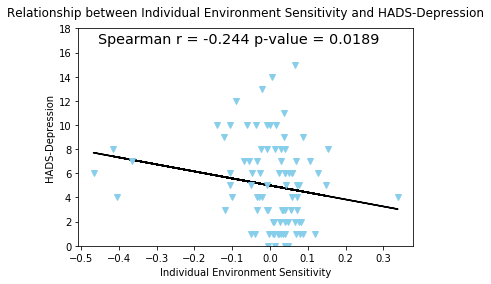

In [200]:
x = check['env_mat']
y = check['depression']

mask = ~np.isnan(x) & ~np.isnan(y)

slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask],y[mask])
line = slope*x+intercept

plt.xlabel("Individual Environment Sensitivity")
plt.ylabel("HADS-Depression")
plt.ylim([0, 18])
plt.plot(x, line, color = 'black')
plt.plot(x,y,'v', color = 'skyblue')
plt.title('Relationship between Individual Environment Sensitivity and HADS-Depression', pad = 12)
plt.annotate('Spearman r = -0.244 p-value = 0.0189', xy=(0.06, 0.93), xycoords='axes fraction', size = 'x-large')

plt.savefig('depression.png', transparent=True, dpi=300, bbox_inches = 'tight')
#plt.scatter(x, y, linewidth=2, color='purple', linestyle='-', marker='o', label="y=x^2")

# Correlation with Questionnaires

In [64]:
scales = pd.read_csv('scale_100.csv', sep = ",")

In [65]:
scales = scales.set_index('id')

In [66]:
scales = scales.drop(['Unnamed: 0'], axis = 1)

In [67]:
scales.index = scales.index.astype(str)

In [68]:
correlation_table = scales.merge(random_effects, right_index = True, left_index = True, how = 'right')

In [69]:
correlation_table['gender'] = correlation_table['gender'].replace('Male', 0)

In [70]:
correlation_table.head(2)

,gender,age,anxiety,depression,tHAD,bAMI,sAMI,eAMI,tAMI,pleasure,physical,cognitive,psychological,total_fatigue,attention,cognitive_instable,motor,perseverance,self_control,cognitive_complexity,attentional_0,motor_0,nonplanning_0,barrat_total,Group,environment_binary[T.1],price_displayed,fatigue
668220.0,0,43.0,0.0,0.0,0.0,0.166667,0.666667,1.166667,0.666667,18.0,0.0,0.0,0.0,0.0,6.0,4.0,16.0,8.0,9.0,8.0,10.0,24.0,17.0,51.0,-0.081051,0.046051,0.003641,-0.000051
668225.0,0,31.0,7.0,5.0,12.0,1.500000,2.666667,0.666667,1.611111,30.0,14.0,12.0,5.0,31.0,9.0,5.0,14.0,7.0,14.0,6.0,14.0,21.0,20.0,55.0,0.119937,-0.107922,-0.087239,-0.000038


In [71]:
len(correlation_table)
# sample size
# lose 1 due to incompletion of questionnaires

94

HADS - The higher the score, the more anxious/depressed you are.
<br>AMI - The higher the score, the more apathetic you are. 
<br>barrat - The higher the score, the more impulsive you are. 
<br>Pleasure - The higher the score, the less pleasure you experience. Thus, higher levels of present state of anhedonia. 
<br>Fatigue - higher scores indicate a greater impact of fatigue on a person’s activities.

In [157]:
ss.spearmanr(correlation_table['depression'], correlation_table['environment_binary[T.1]'], nan_policy = 'omit')

SpearmanrResult(correlation=-0.23386325868968066, pvalue=0.024059514877133568)

In [158]:
ss.spearmanr(correlation_table['anxiety'], correlation_table['environment_binary[T.1]'], nan_policy = 'omit')

SpearmanrResult(correlation=-0.13371477906883256, pvalue=0.20131807518311529)

In [159]:
ss.spearmanr(correlation_table['bAMI'], correlation_table['environment_binary[T.1]'],nan_policy = 'omit')

SpearmanrResult(correlation=-0.03929175566680551, pvalue=0.7084521606974978)

In [160]:
ss.spearmanr(correlation_table['nonplanning_0'], correlation_table['price_displayed'],nan_policy = 'omit')

SpearmanrResult(correlation=-0.20209765720464265, pvalue=0.052052846441191965)

## Linear regression bewteen env betas and depression + age + gender

In [174]:
from sklearn.linear_model import LinearRegression

In [175]:
correlation_table.isnull().sum()
correlation_table = correlation_table[correlation_table.depression.notnull()]

In [176]:
x_depression_control = correlation_table[['age', 'gender', 'depression']]
y_env = correlation_table['environment_binary[T.1]']

In [177]:
clf = linear_model.LinearRegression()

In [178]:
clf.fit(x_depression_control, y_env)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [179]:
clf.coef_

array([ 0.00085412,  0.00867271, -0.00513921])

In [180]:
sk.feature_selection.f_regression(x_depression_control, y_env, center=True)

(array([1.16103917, 0.46181509, 2.94740968]),
 array([0.28409825, 0.49850192, 0.08941731]))

# Run an overall heatmap

In [91]:
AMI_barrat_HADS = correlation_table[['price_displayed', 'environment_binary[T.1]','anxiety', 'depression', 'tHAD','bAMI', 'sAMI', 'eAMI', 'tAMI',
                                    'attention', 'cognitive_instable', 'motor', 'perseverance', 
                             'self_control', 'cognitive_complexity', 'attentional_0', 'motor_0', 
                             'nonplanning_0', 'barrat_total']]

In [92]:
def compute_corr_and_p(df1, df2):
    corrs = pd.DataFrame(index=df1.columns, columns=df2.columns, dtype=np.float64)
    pvals = corrs.copy()
    for i, j in product(df1.columns, df2.columns):
        corrs.loc[i,j], pvals.loc[i,j] = ss.spearmanr(df1[i], df2[j], nan_policy = 'omit')
    return corrs, pvals

In [93]:
corrs, pvals = compute_corr_and_p(AMI_barrat_HADS, AMI_barrat_HADS)

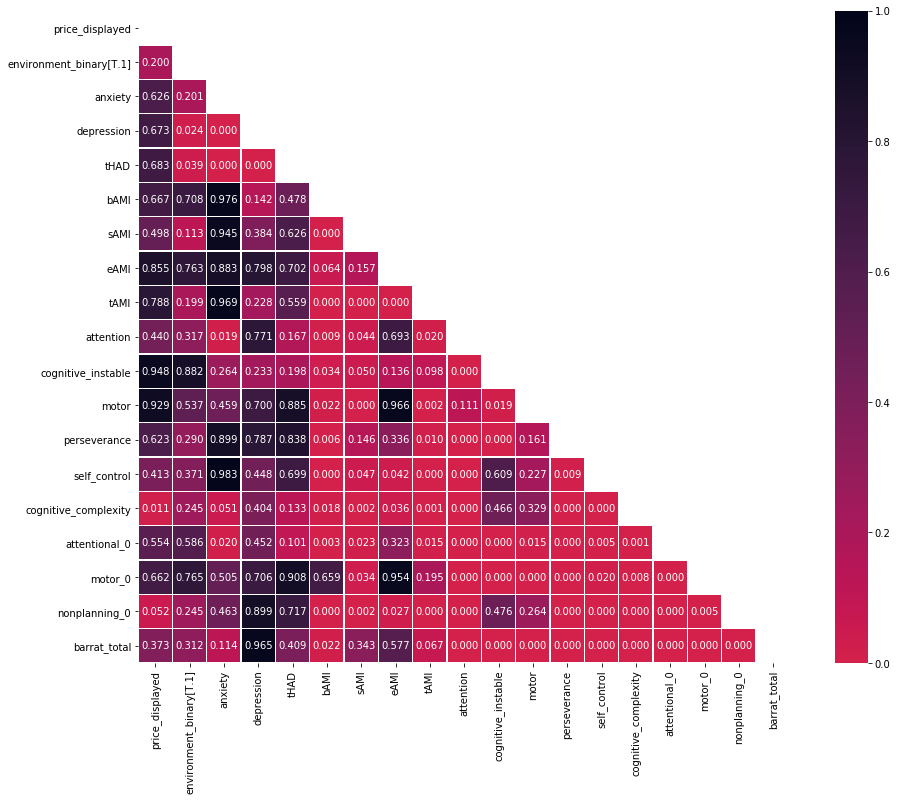

In [106]:
plt.figure(figsize=(16, 12))
mask = np.zeros_like(pvals, dtype=np.bool)
mask[np.triu_indices_from(pvals)] = True
ax = sns.heatmap(
    pvals, 
    vmin=0, vmax=1, center=0.05,
    cmap= sns.cm.rocket_r,
    square=True,
    annot=True, linewidths=.5, fmt = '.3f', mask = mask
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
);
plt.savefig('pvals_heatmap.png', transparent = True, dpi = 300)